# Titanic SVM
This is an Python implementation of the kaggle Titanic challenge https://www.kaggle.com/c/titanic.
The feature engineering is done mostly with Numpy and Pandas, while the plotting is done with seaborn respectively matplotlib. Finally, besides some Machine Learning tools from the SciKit, we implemented our own SMO algorithm based on http://cs229.stanford.edu/materials/smo.pdf.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import re

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
#sns.set()
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
sns.set_style({'font.sans-serif': [
    u'Source Sans Pro',
    u'Arial',
    u'DejaVu Sans',
    u'Liberation Sans',
    u'Bitstream Vera Sans',
    u'sans-serif']})

pylab.rcParams[ 'figure.figsize' ] = 8 , 6
pylab.rcParams[ 'font.size' ] = 18
pylab.rcParams[ 'xtick.labelsize' ] = 16
pylab.rcParams[ 'ytick.labelsize' ] = 16
pylab.rcParams[ 'legend.fontsize' ] = 16


## Helper Functions

In [2]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = train.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

## Load Data

In [3]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
full = [train, test]

## Feature Analysis

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Variable Description

- **Survived:** Survived (1) or died (0)
- **Pclass:** Passenger's class
- **Name:** Passenger's name
- **Sex:** Passenger's sex
- **Age:** Passenger's age
- **SibSp:** Number of siblings/spouses aboard
- **Parch:** Number of parents/children aboard
- **Ticket:** Ticket number
- **Fare:** Fare
- **Cabin:** Cabin
- **Embarked:** Port of embarkation


In [5]:
train.describe() # kann das weg?

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Missing Data

Our datasets contain missing in some features. First we need to see which features are incomplete, so we can think about what to do with our missing data.

In [6]:
print("Missing Training Data (relative) \n")
print(train.isnull().sum()/train.shape[0]*100)
print("\n Missing Test Data (relative) \n")
print(test.isnull().sum()/test.shape[0]*100)

Missing Training Data (relative) 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

 Missing Test Data (relative) 

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


**This implies that `Cabin` is an inadequate feature.**

# Feature Selection

## Does Age Matter?

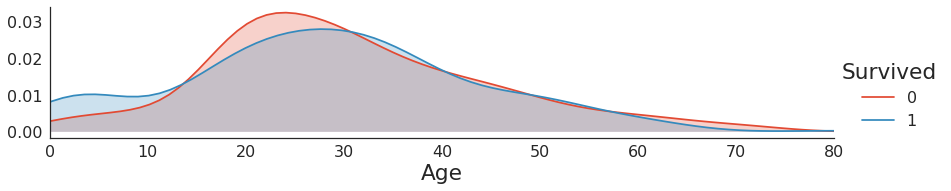

In [7]:
plot_distribution( train , var = 'Age' , target = 'Survived')
plt.savefig('media/age_all.pdf')

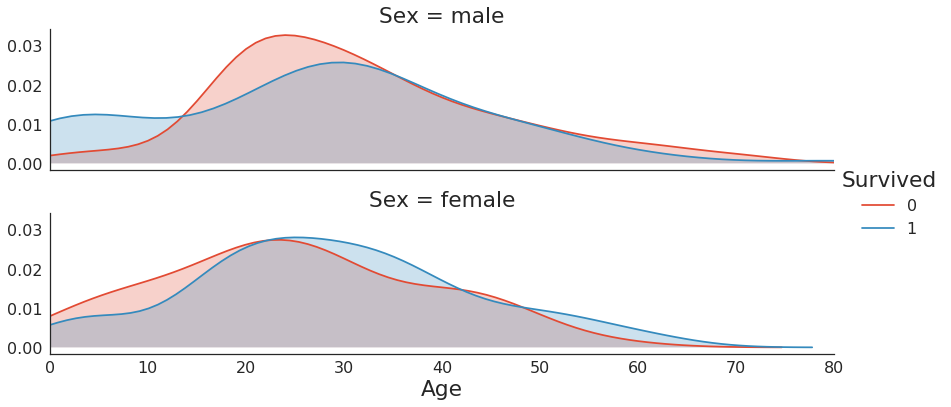

In [8]:
plot_distribution( train , var = 'Age' , target = 'Survived', row='Sex')
plt.savefig('media/age_sex.pdf')

**Observation:**
- Age does not seperate satisfactory

## Does Sex Matter?

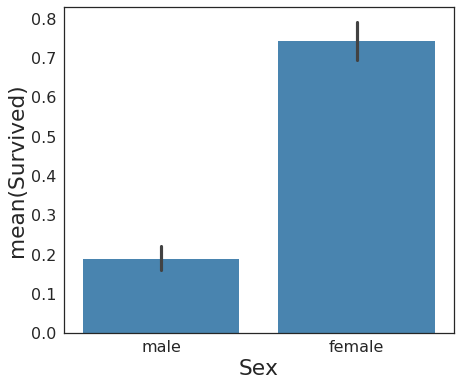

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 6))
sns.barplot(data=train, x = 'Sex', y = 'Survived', ax = ax1, palette=sns.color_palette("Blues_d", 1))
plt.savefig('media/sex_survived.pdf')

The above plot shows that female passengers had a much better chance to survive! This implies that sex is an important feature for our predictions.

## Port of Embarkation

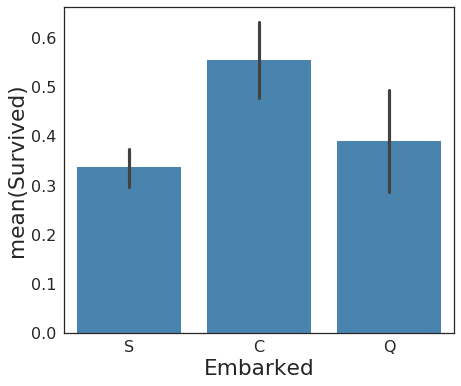

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 6))
sns.barplot(data=train, x = 'Embarked', y = 'Survived', ax = ax1, palette=sns.color_palette("Blues_d", 1))
plt.savefig('media/embarkation_survived.pdf')

**Observation:** Seems to be important.
The Embarked-feature can not be sortet in a meaningful way, so we make 3 binary features.

## Strip Names down to their Titles
Obviously the Name itself does not give us important information and is therefore not good feature for our learning machine.

In [11]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

Let's group the minorities together to a `Res` group:

In [12]:
def group_titles(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        name = title_search.group(1)
        if name in ['Mr', 'Miss', 'Mrs', 'Master']:
            return name
        else:
            return 'Res'
    return ""

plot_all_titles = train.copy()
train['Title'] = train['Name'].apply(group_titles)
test['Title'] = test['Name'].apply(group_titles)

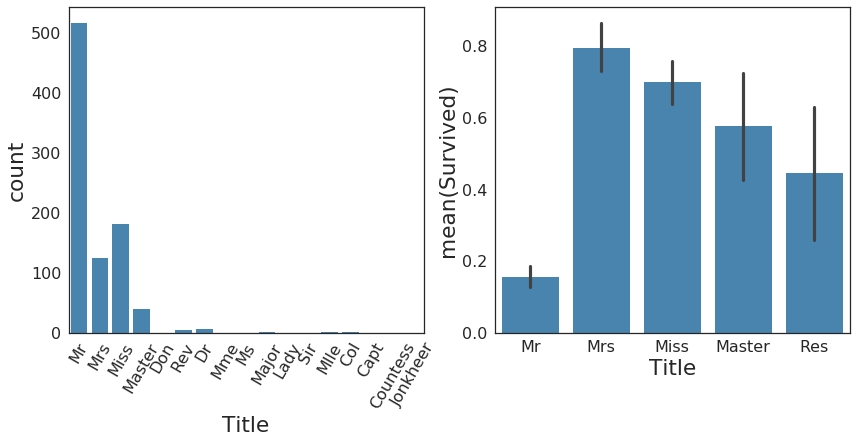

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax1)
plt.xticks(rotation=60)
sns.countplot(data=plot_all_titles, x = 'Title', ax = ax1, palette=sns.color_palette("Blues_d", 1))
sns.barplot(data=train, x = 'Title', y = 'Survived', ax = ax2, palette=sns.color_palette("Blues_d", 1))
plt.savefig('media/title.pdf')

## Cabin number

In [14]:
train.loc[train.Cabin.isnull()==False, 'Cabin'] = 1 # cabinnumber known
train.loc[train.Cabin.isnull(), 'Cabin'] = 0        # cabinnumber unknown
train["Cabin"] = train["Cabin"].astype(int)         # to int
test.loc[test.Cabin.isnull()==False, 'Cabin'] = 1 # cabinnumber known
test.loc[test.Cabin.isnull(), 'Cabin'] = 0        # cabinnumber unknown
test["Cabin"] = test["Cabin"].astype(int)         # to int

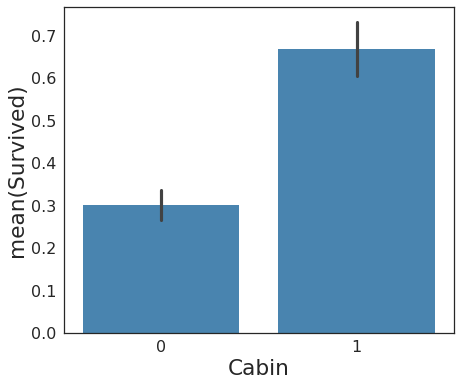

In [15]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 6))
sns.barplot(data=train, x = 'Cabin', y = 'Survived', ax = ax1, palette=sns.color_palette("Blues_d", 1))
plt.savefig('media/cabin_survived.pdf')

## Family Size

In [16]:
train["Family_Size"] = train.loc[:, ["SibSp", "Parch"]].sum(axis=1)
train.loc[:, "Family_Size"] = pd.cut(train.Family_Size, [0, 1, 4, np.inf],
                                        right=False,
                                        labels=['alone', 'small_fam', 'big_fam'])
test["Family_Size"] = test.loc[:, ["SibSp", "Parch"]].sum(axis=1)
test.loc[:, "Family_Size"] = pd.cut(test.Family_Size, [0, 1, 4, np.inf],
                                        right=False,
                                        labels=['alone', 'small_fam', 'big_fam'])

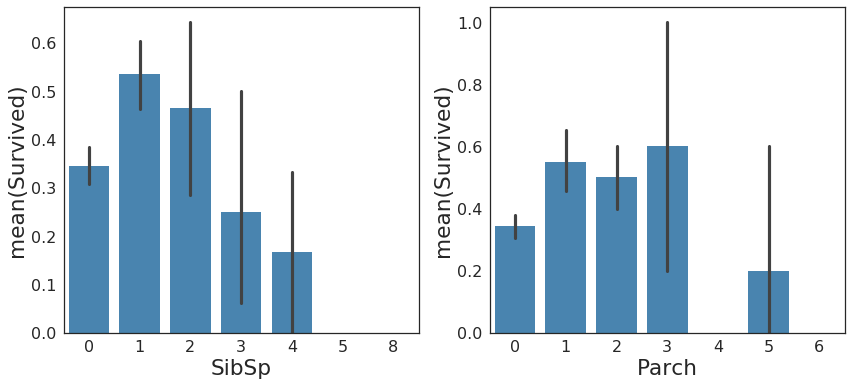

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=train, x = 'SibSp', y = 'Survived', ax = ax1, palette=sns.color_palette("Blues_d", 1))
sns.barplot(data=train, x = 'Parch', y = 'Survived', ax = ax2, palette=sns.color_palette("Blues_d", 1))
plt.savefig('media/family_size_before.pdf')

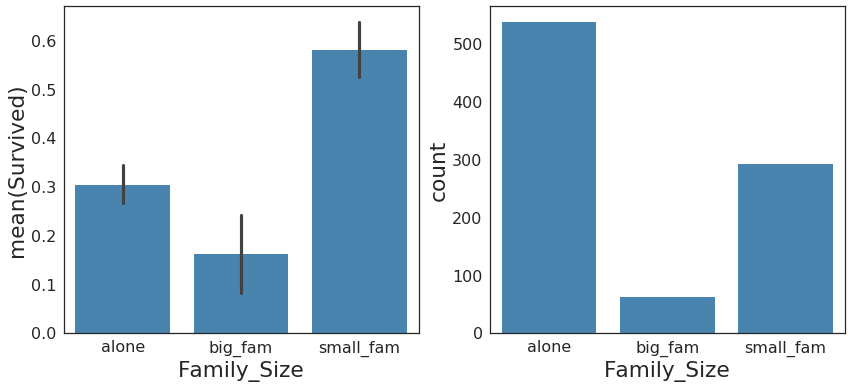

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=train, x = 'Family_Size', y = 'Survived', ax = ax1, palette=sns.color_palette("Blues_d", 1))
sns.countplot(data=train, x="Family_Size", ax=ax2, palette=sns.color_palette("Blues_d", 1))
plt.savefig('media/family_size_after.pdf')

## Does Money Matter?

### PClass

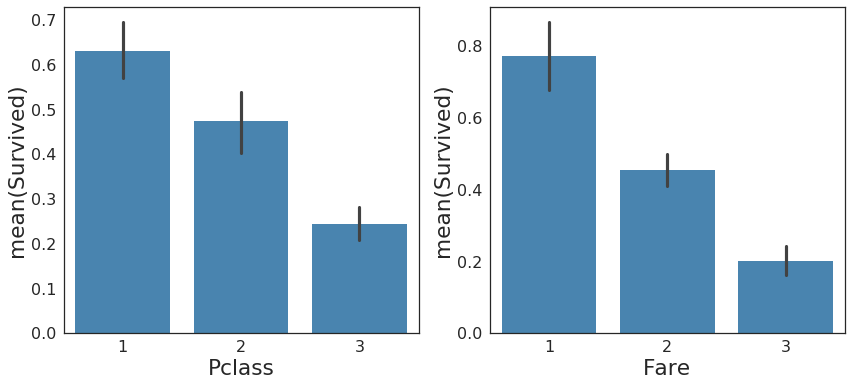

In [19]:
train['Fare'] = pd.cut(train['Fare'], bins=[0, 10, 80, np.inf], include_lowest=True, labels=[3, 2, 1]).astype(int)
test['Fare'] = pd.cut(test['Fare'], bins=[0, 10, 80, np.inf], include_lowest=True, labels=[3, 2, 1]).astype(int)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=train, x = 'Pclass', y = 'Survived', ax = ax1, palette=sns.color_palette("Blues_d", 1))
sns.barplot(data=train, x = 'Fare', y = 'Survived', ax = ax2, palette=sns.color_palette("Blues_d", 1))
plt.savefig('media/fare_survived.pdf')

## Make All Variables Numeric

In [20]:
train.loc[:, ['Sex', 'Embarked', 'Title', 'Family_Size']] = \
    train.replace( {'Sex': {'female': 1, 'male': 0},
                    'Family_Size': {'alone': 0, 'small_fam': 1, 'big_fam': 2}
                    }).loc[:, ['Sex', 'Embarked', 'Title', 'Family_Size']]
test.loc[:, ['Sex', 'Embarked', 'Title', 'Family_Size']] = \
    test.replace( {'Sex': {'female': 1, 'male': 0},
                   'Family_Size': {'alone': 0, 'small_fam': 1, 'big_fam': 2}
                   }).loc[:, ['Sex', 'Embarked', 'Title', 'Family_Size']]

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,3,0,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,2,1,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,3,0,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,2,1,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,3,0,S,Mr,0


## Correlation Map

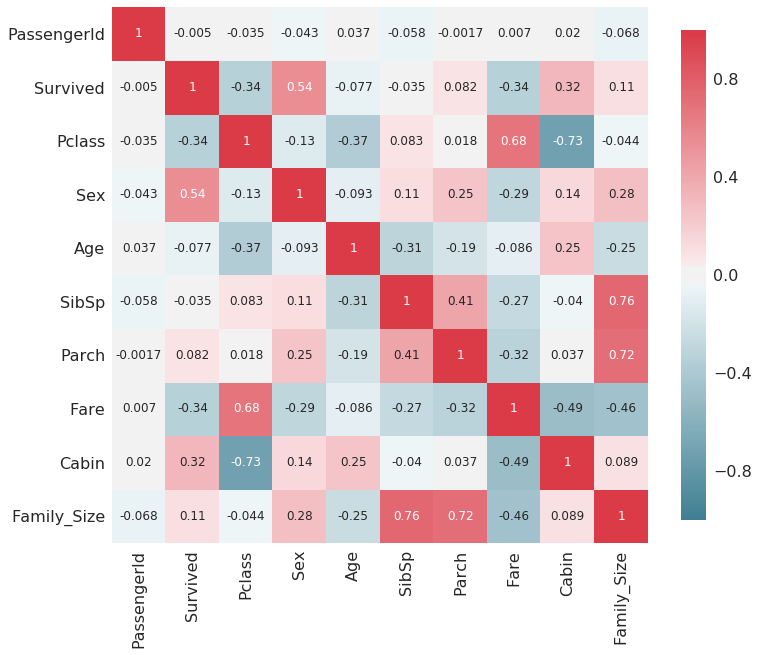

In [22]:
plot_correlation_map(train)
plt.savefig('media/correlation_map.pdf')

## Binary Categories

### Embarked

In [23]:
res = pd.get_dummies(train["Embarked"], prefix="Embarked_at")
train = pd.concat([train, res], axis=1)
res = pd.get_dummies(test["Embarked"], prefix="Embarked_at")
test = pd.concat([test, res], axis=1)
res.head(3)

,Embarked_at_C,Embarked_at_Q,Embarked_at_S
0,0,1,0
1,0,0,1
2,0,1,0


In [24]:
res = pd.get_dummies(train["Title"], prefix="Title")
train = pd.concat([train, res], axis=1)
res = pd.get_dummies(test["Title"], prefix="Title")
test = pd.concat([test, res], axis=1)
res.head(3)

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Res
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,1,0,0


## Missing Values for Age

In [25]:
# female = 1; male = 0
for i in range(1,4):
    # Iterating through Passenger Classes (1, 2, 3)
    av_female_young = train.loc[(train.Age <= 20) & (train.Sex == 1) & (train.Pclass==i), "Age"].mean()
    av_female_old = train.loc[(train.Age > 20) & (train.Sex == 1) & (train.Pclass==i), "Age"].mean()
    av_male_young = train.loc[(train.Age <= 18) & (train.Sex == 0) & (train.Pclass==i), "Age"].mean()
    av_male_old = train.loc[(train.Age > 18) & (train.Sex == 0) & (train.Pclass==i), "Age"].mean()

    train.loc[(train.Age.isnull()) & (train.Sex == 1) & (train.Title_Miss == 1) & (train.Pclass==i), "Age"] = av_female_young
    train.loc[(train.Age.isnull()) & (train.Sex == 1) & (train.Title_Miss != 1) & (train.Pclass==i), "Age"] = av_female_old
    train.loc[(train.Age.isnull()) & (train.Sex == 0) & (train.Title_Master == 1) & (train.Pclass==i), "Age"] = av_male_young
    train.loc[(train.Age.isnull()) & (train.Sex == 0) & (train.Title_Master != 1) & (train.Pclass==i), "Age"] = av_male_old


## Drop Data
Now we can drop data, that is not important for us.

In [26]:
drop_this = ['SibSp', 'Ticket', 'Name', 'Parch', 'Embarked', 'Title']
train = train.drop(drop_this, axis=1)
test = test.drop(drop_this, axis=1)



## Prepare Train Data For Validated Fitting



In [27]:
train.index = train.PassengerId
train = train.drop(['PassengerId'], axis=1)

## Scaling the Data

In [28]:
from sklearn.preprocessing import scale
'''
Remove all rows containing nans because algorithms cant deal with that shit. 
'''
train = train.dropna()

# MinMaxScaler
train_min = train.min(axis=0)
train_max = train.max(axis=0)
train = train.subtract(train_min, axis = 'columns').divide(train_max-train_min, axis='columns')

## Split the Data

In [29]:
from sklearn.model_selection import train_test_split

# Split
X_all = train.drop('Survived', axis=1)
y_all = train['Survived']

# Split up train data in temporary train and test parts
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

# Fitting with SciKit SVM


In [30]:
# Modelling Algorithms
from sklearn import svm

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = svm.SVC()

# Choose some parameter combinations to try
parameters = {'C': [1.0, 10.0, 50., 100., 200.]}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
# Testing
score_svm = clf.score(X_test, y_test) *100
print("Test-Score: %s" % score_svm)

Test-Score: 81.5642458101


## Validation with K-Fold

In [32]:
def kfold(clf, X_all, y_all, cv=5):
    """ Calculates K-Fold accuracy
    """
    n_samples = len(y_all)
    score = np.zeros(cv)
    idx_test = np.zeros(y_all.shape).astype(bool)
    
    fold_sizes = (n_samples // cv) * np.ones(cv, dtype=np.int)
    fold_sizes[:n_samples % cv] += 1 # The first n_samples % cv sizes are n_samples // cv += 1
    ix = np.zeros(cv, dtype=int)
    ix[1:] = np.cumsum(fold_sizes)[:-1]
    
    for i in range(cv):
        idx_test[:] = False
        idx_test[ix[i]:ix[i]+fold_sizes[i]] = True 
        idx_train = ~idx_test
        
        X_test, y_test = X_all[idx_test], y_all.iloc[idx_test]
        X_train, y_train = X_all[idx_train], y_all.iloc[idx_train]
        
        clf.fit(X_train, y_train)
        score[i] = accuracy_score(y_test, clf.predict(X_test))
    
    return score

In [33]:
scores_svm = kfold(clf, X_all, y_all, cv=5)
print(r"K-Fold validation yealds a mean acurracy of %f +- %f %%" % (scores_svm.mean(), scores_svm.std()/scores_svm.mean()))

K-Fold validation yealds a mean acurracy of 0.824882 +- 0.037095 %


# Using Our own SVM

### First some little test with a simple 2D setup

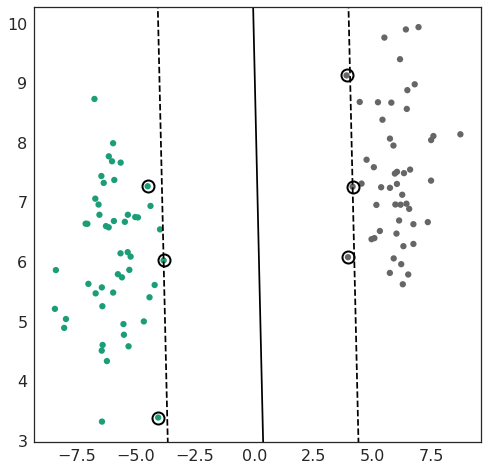

In [59]:
from own_svm.own_svm import OwnSMOsimple

# Simple Validation
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs

X, y = make_blobs(n_features=2, centers=2)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

X_all_simple = pd.DataFrame(X)
y_all_simple = pd.DataFrame(y)
y_all_simple = y_all_simple[0]


own = OwnSMOsimple()
own.fit(X_all_simple, y_all_simple, tol=1e-8, max_passes=25, kernel="linear")

####################################
# Plot support vectors and margins #
####################################

def perpendicular(a):
    """
    calc perpendicular vector to a in 2D
    """
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b


def plot_plane(direction, local = [0, 0], style='k'):
    """
    plot a line from direction and local vector
    """
    multipliers = np.linspace(-1000, 1000, 20)
    line = [(local + multiplier * direction) for multiplier in multipliers]
    x_coords = [point[0] for point in line]
    y_coords = [point[1] for point in line]
    plt.plot(x_coords, y_coords, style)

w = own.get_w()
abs_w = np.linalg.norm(w)
margin = 1/abs_w

v_1, v_2 = own.get_support_vectors()
b = own.b

direction_vector = perpendicular(w)
local_vector = -(own.b/abs_w**2) * w
abs_localvector = np.linalg.norm(local_vector)

mu_local = local_vector/abs_localvector * (abs_localvector + margin)
md_local = local_vector/abs_localvector * (abs_localvector - margin)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_all_simple.loc[:,0],X_all_simple.loc[:,1], c=np.transpose(y_all_simple), s=40 , cmap='Dark2', lw=0)
plt.xlim(ax.get_xlim())
plt.ylim(ax.get_ylim())

plot_plane(direction_vector, local_vector)       # hyperplane
plot_plane(direction_vector, md_local, '--k')      # downer margin
plot_plane(direction_vector, mu_local, '--k')      # upper margin

plt.plot(v_2[:,0], v_2[:,1], 'o', markersize=12, markeredgecolor='k', markeredgewidth=2, markerfacecolor='None') # Support Vectors
plt.plot(v_1[:,0], v_1[:,1], 'o', markersize=12, markeredgecolor='k', markeredgewidth=2, markerfacecolor='None')  # Support Vectors
plt.savefig('media/own_test.pdf')

### Now using the Titanic dataset

In [60]:
own = OwnSMOsimple()
own.fit(X_train, y_train)

In [61]:
print("Test-Score: %s" % own.score(X_test, y_test))

Test-Score: 0.798882681564


In [37]:
score_own = own.score(X_test, y_test)
# Takes a lot of time!
#scores_own = kfold(own, X_all, y_all, cv=5)
#print(r"K-Fold validation yealds a mean acurracy of %f +- %f %%" % (scores_own.mean(), scores_own.std()/scores_own.mean()))

# Benchmarking

Just for the sake of completness and to get an imagination of how much you can speed up the algorithm. Our implementation will obviously perform worse since we did not focus on performance optimization at all and used a very naive smo algorithm.

In [38]:
import timeit

# Seperat the Trainingset in to parts of different sizes
parts = np.linspace(0.0, 0.5, 6)[1:]
n = parts * X_all.shape[0]

t_scikit = np.zeros(n.shape)
t_own = np.zeros(n.shape)

# Time Consuming
#for i in range(len(parts)):
#  X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=parts[i], random_state=23)
#  t_scikit[i] = timeit.timeit(stmt='clf.fit(X_train, y_train)', setup="from __main__ import clf, X_train, y_train", number=2)
#  t_own[i] = timeit.timeit(stmt='own.fit(X_train, y_train)', setup="from __main__ import own, X_train, y_train", number=2)   


nan


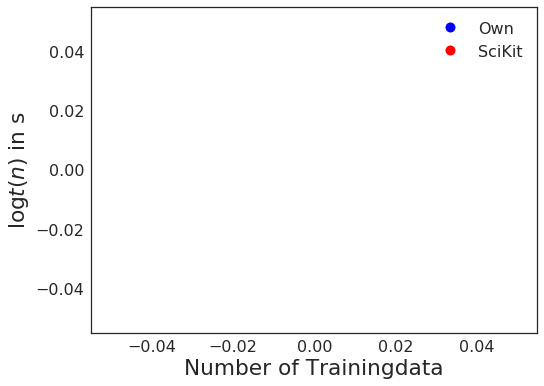

In [39]:
plt.plot(n, np.log(t_own), "ob", markersize=10, label="Own")
fit = np.polyfit(n,np.log(t_own),1)
abs_own = fit[1]
fit_fn = np.poly1d(fit)
plt.plot(n, fit_fn(n), '--b')

plt.plot(n, np.log(t_scikit), "or", markersize=10, label="SciKit")
fit = np.polyfit(n,np.log(t_scikit),1)
print(fit[1] - abs_own)
fit_fn = np.poly1d(fit)
plt.plot(n, fit_fn(n), '--r')

plt.legend()
plt.xlabel("Number of Trainingdata")
plt.ylabel(r"$\log t(n)$ in s")
plt.savefig('media/benchmark.pdf')

**Conclusion:**
- As expected, our algorithm performs way worse than the optimized scikit implemantion
- The exponential behaviour is almost twice as worce since the blue line has a slope of ~0.0084 while the red on has a slope of ~0.0051
- Huge difference in prefactor as well since differnec of the intercepts is around 6

# Comparison of Different Machines

Partly taken from: https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
scores_knn = kfold(knn, X_all, y_all, cv=5)

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
scores_gaussian = kfold(gaussian, X_all, y_all, cv=5)

# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
scores_decision_tree = kfold(decision_tree, X_all, y_all, cv=5)

models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Decision Tree', 'Gaussian Native Bayes', 'Own SVM'],
    'Score': [scores_svm.mean(), scores_knn.mean(), scores_decision_tree.mean(), scores_gaussian.mean(), score_own]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.824882
2,Decision Tree,0.801343
1,KNN,0.791256
4,Own SVM,0.782123
3,Gaussian Native Bayes,0.774459


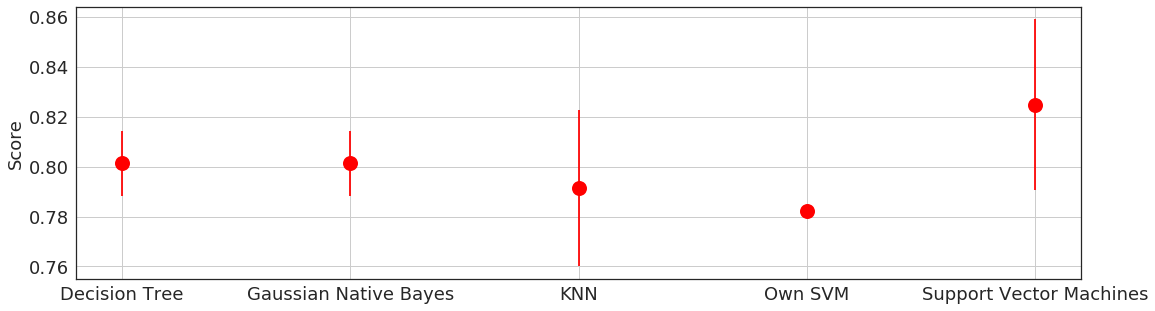

In [41]:
models = pd.DataFrame({
    'Support Vector Machines': scores_svm,
    'KNN': scores_knn,
    'Decision Tree':scores_decision_tree,
    'Gaussian Native Bayes': scores_decision_tree,
    'Own SVM':  np.array(5*[score_own])
    #'Own SVM':  scores_own
})

fig= plt.figure( figsize=(18,5))
x = np.arange(len(models.columns))
plt.xticks(x, models.columns)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.errorbar(x, models.mean(), yerr=models.std(), fmt='ro', markersize=15.)
plt.ylabel("Score", fontsize=18)
ax = fig.gca()

plt.savefig('media/ml_comparison.pdf')

## TODO:
### Neu
- 2D Plots mit Stützvektoren 
- Just 4 Fun: Performance Vergleich
- Sbl&Parch einbauen maybe (isalone)
- Vergleich mit anderen Maschinen
- Maybe unseren SVM noch ein bisschen auseinander ficken mit anderen Datensätzen
- **Machen features Sinn?** -> ausprobieren
- Ausprobieren ob Reihenfolge n Unterschied macht


### Verbessern
- Plots nicer machen - Zu jedem feature n Plot
- Code besser verstehen: E_i setc..
- Features noch optimieren
- Notebook ausformulieren (was ins Notebook was ins Latex Doc)
- Latex Doc machen

### Notizen
- Feature Labels sortieren: JA https://stackoverflow.com/questions/12946373/how-do-i-do-use-non-integer-string-labels-with-svm-from-scikit-learn-python ; https://www.quora.com/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together
- 